# <center><big>AIcrowd - Aircraft localization competition</big> <br /> <medium>(round 1: synchronized receivers)</medium></center>

## <center>Part I - Exploratory analysis and a simple solution</center>

### Link to competition page
https://www.aicrowd.com/challenges/cyd-campus-aircraft-localization-competition

In [1]:
from IPython.core.pylabtools import figsize
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

## Datasets

There were 8 datasets provided:
 - 7 training ones (where all aircraft locations are known);
 - 1 testing dataset (where some locations are missed).
 
The goal of the competition was to predict at least 50% of missing locations in the testing dataset.

During the competition I used only the test dataset to train my models and make predictions.
I thought that 7 training datasets were recorded at different times and therefore may include clock
drifts.

**Here and below by train and test datasets I will assume the training (with known locations) and testing parts of the TEST dataset.**

In [2]:
### Recorded measurements

df = pd.read_csv('test/round1_competition.csv')
print('Data shape:', df.shape)
display(df.head(3))

# Information about sensors

sensors = pd.read_csv('test/sensors.csv')
print('Sensors shape', sensors.shape)
sensors.head(3)

Data shape: (1836730, 9)


,id,timeAtServer,aircraft,latitude,longitude,baroAltitude,geoAltitude,numMeasurements,measurements
0,1,0.0,109,51.606740,-0.204849,2590.80,2590.80,2,"[[532,969020406,89],[216,969100125,23]]"
1,2,0.0,840,51.280781,-0.698624,8907.78,8846.82,2,"[[532,976779968,72],[216,976836703,32]]"
2,3,0.0,1819,51.354567,-0.304184,5791.20,5722.62,2,"[[532,980862171,91],[294,980898968,101]]"


Sensors shape (716, 5)


,serial,latitude,longitude,height,type
0,1,46.681067,7.665313,680.9232,SBS-3
1,2,40.337042,-3.770206,735.7872,SBS-3
2,3,0.000000,0.000000,0.0000,SBS-3


### Number of unique aircrafts in train and test

In [3]:
print('Number of unique aircrafts', len(df.aircraft.unique()))

### Mark test records
df['test'] = df.latitude.apply(lambda x: int(np.isnan(x)))

print('Number of aircrafts with unknown location', len(df[df.test==1].aircraft.unique()))

Number of unique aircrafts 1635
Number of aircrafts with unknown location 32


### Stations / sensors

In [4]:
# Create a column with all station numbers which provided measurements for a given location
df = df.assign(stations = lambda x: x.measurements.apply(lambda y: [z[0] for z in eval(y)]))

# Find all stations with records for the test
# (It will be shown in Part 2 - Main solution that 3+ measurements are required to solve multilateration equations)
test_stations = df[(df.test == 1) & (df.numMeasurements > 2)].stations.values.tolist()

stations = []
for s in test_stations:
    stations += s

print('Number of unique stations', len(set(stations)))

Number of unique stations 33


In [5]:
## So, there are only 33 stations which measurements included in test!

In [6]:
stations = list(set(stations))
print(len(stations))

33


In [7]:
# How many records there are in train with the selected stations

In [8]:
train = (df[(df.test == 0) & (df.numMeasurements > 2)]
         .assign(interest = lambda x: [int(all([i in stations for i in y])) for y in x.stations])
         .loc[lambda x: x.interest == 1]
        )

print(train.shape)
train.head(3)

(671959, 12)


,id,timeAtServer,aircraft,latitude,longitude,baroAltitude,geoAltitude,numMeasurements,measurements,test,stations,interest
3,4,0.001,719,46.953053,14.289973,10972.80,10820.40,3,"[[149,957322046,48],[143,957512484,102],[133,9...",0,"[149, 143, 133]",1
8,9,0.010,755,49.933136,7.514576,11582.40,11376.66,5,"[[663,991949296,84],[398,992213375,94],[460,99...",0,"[663, 398, 460, 414, 550]",1
9,10,0.012,901,47.345627,6.464218,11399.52,11231.88,4,"[[147,1000432156,69],[470,1000187995,32],[124,...",0,"[147, 470, 124, 474]",1


### Remove location outliers

Some points are far away from their tracks which need to be removed

In [9]:
from tqdm import tqdm

# list of broken ids
broken_id = []

## Loop over aircrafts
for r in tqdm(train.aircraft.unique()):
    
    # apply a median filter for latitude values
    # true direction
    lat1 = train[train.aircraft==r].latitude.rolling(15).median().values
    # reverse direction
    lat2 = train[train.aircraft==r].latitude.sort_index(ascending=False).rolling(15).median().values[::-1]
    # combine them together
    lat = [0.5*(x+y) if not np.isnan(x) and not np.isnan(y) else x if not np.isnan(x) else y for x, y in zip(lat1, lat2)]

    # apply a median filter for longitude values
    # true direction
    lon1 = train[train.aircraft==r].longitude.rolling(15).median().values
    # reverse direction
    lon2 = train[train.aircraft==r].longitude.sort_index(ascending=False).rolling(15).median().values[::-1]
    # combine them together
    lon = [0.5*(x+y) if not np.isnan(x) and not np.isnan(y) else x if not np.isnan(x) else y for x, y in zip(lon1, lon2)]
    
    # filter outliers by a threshold
    lat = train[train.aircraft==r].latitude.values - np.array(lat)
    lon = train[train.aircraft==r].longitude.values - np.array(lon)
    
    ind = np.unique(np.r_[np.where(abs(lat) > 0.2)[0], np.where(abs(lon) > 0.2)[0]])

    broken_id += train[train.aircraft==r].id.values[ind].tolist()

100%|██████████| 1068/1068 [00:17<00:00, 59.50it/s] 


In [10]:
# Number of outliers found

In [11]:
len(broken_id)

7625

In [12]:
# Remove outliers

In [13]:
train = train[~train.id.isin(broken_id)]
print(train.shape)

(664334, 12)


## Altitude measurements

Text(0, 0.5, 'geoAltitude')

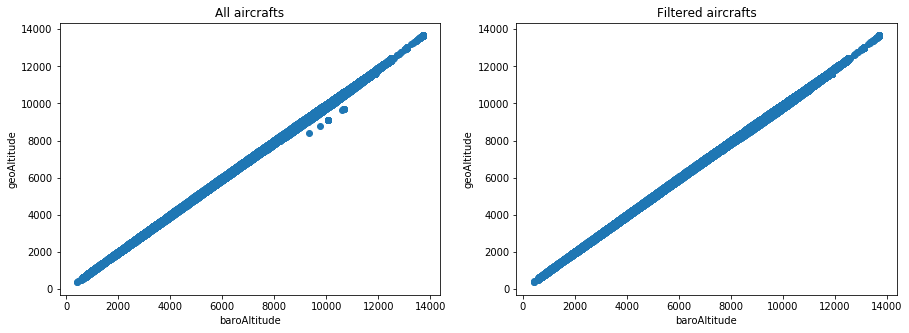

In [14]:
figsize(15, 5)

f = plt.figure()
ax1 = f.add_subplot(121)
ax1.scatter(train.baroAltitude,
            train.geoAltitude)
ax1.set_title('All aircrafts')
ax1.set_xlabel('baroAltitude')
ax1.set_ylabel('geoAltitude')

# 2 aircrafts seems to have outliers
ax2 = f.add_subplot(122)
ax2.scatter(train[~train.aircraft.isin([1120, 415])].baroAltitude,
            train[~train.aircraft.isin([1120, 415])].geoAltitude)
ax2.set_title('Filtered aircrafts')
ax2.set_xlabel('baroAltitude')
ax2.set_ylabel('geoAltitude')

In [15]:
# Apply spline interpolation to find geoAltitude as a function of baroAltitude
# (Linear interpolation shows worse result)

In [16]:
from scipy.interpolate import splrep, splev

ind = np.argsort(train[~train.aircraft.isin([1120, 415])].baroAltitude.values)

spl = splrep(train[~train.aircraft.isin([1120, 415])].baroAltitude.values[ind],
             train[~train.aircraft.isin([1120, 415])].geoAltitude.values[ind],
             k=2, t=[5000, 10000], task=-1)

In [17]:
# Check result

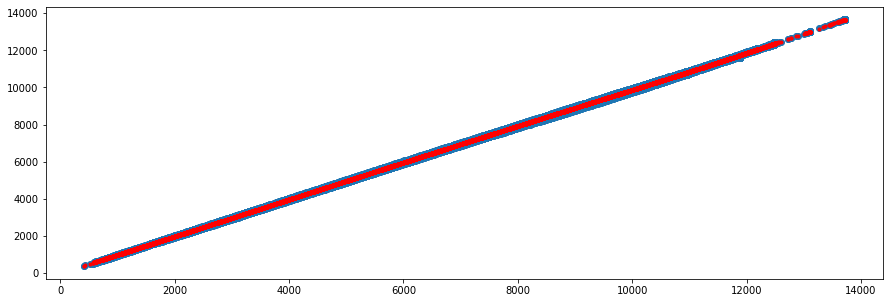

In [18]:
figsize(15, 5)

plt.scatter(train[~train.aircraft.isin([1120, 415])].baroAltitude,
            train[~train.aircraft.isin([1120, 415])].geoAltitude)
plt.plot(train[~train.aircraft.isin([1120, 415])].baroAltitude.values,
         splev(train[~train.aircraft.isin([1120, 415])].baroAltitude.values, spl), 'r.')

In [19]:
# Remove two aircrafts from train

In [20]:
train = train[~train.aircraft.isin([1120, 415])]

### Altitudes of test tracks

Just to show how the test data looks like.

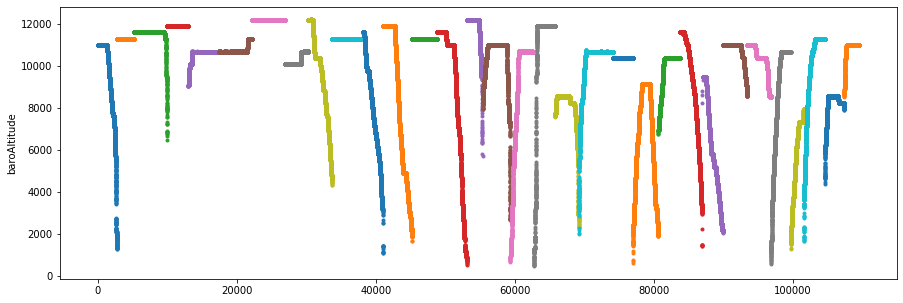

In [21]:
figsize(15, 5)

i = 0

for r in df[df.test==1].aircraft.unique():
    d = df[(df.test==1)&(df.aircraft==r)].baroAltitude.values
    plt.plot(range(i, i+d.shape[0]), d, '.')
    i += d.shape[0]
    
_ = plt.ylabel('baroAltitude')

## Plot tracks

In [22]:
# Function to plot multiple tracks
#
# Input:
#   - df: dataframe with measurements
#   - tracks: a list of aircraft numbers to plot
#   - xpad: additional padding for longitude (deg)
#   - ypad: additional padding for latitude (deg)
#
# Output: None

def plot_track(df, tracks, xpad=0.2, ypad=1):
    
    df = df[df.aircraft.isin(tracks)]
    lon_min, lon_max = df.longitude.min(), df.longitude.max()
    lat_min, lat_max = df.latitude.min(), df.latitude.max()
    
    s = sensors[(sensors.longitude > lon_min - xpad) &
                (sensors.longitude < lon_max + xpad) &
                (sensors.latitude > lat_min - ypad) &
                (sensors.latitude < lat_max + ypad) &
                (sensors.serial.isin(stations))]
    
    figsize(15, 5)
    
    f = plt.figure()
    ax1 = f.add_subplot(121)
    track = ax1.scatter(df.longitude, df.latitude, c = df.geoAltitude)
    
    ax1.scatter(s.longitude, s.latitude, c='r', marker='x')
    for i in range(s.shape[0]):
        ax1.text(s.longitude.values[i], s.latitude.values[i], str(s.serial.values[i]))
    
    ax1.set_xlim([lon_min - xpad, lon_max + xpad])
    ax1.set_ylim([lat_min - ypad, lat_max + ypad])
    
    ax1.set_title('Aircraft track')
    ax1.set_xlabel('Longitude')
    ax1.set_ylabel('Latitude')
    f.colorbar(track)
    
    ax2 = f.add_subplot(122)
    height = ax2.scatter(df[df.aircraft.isin(tracks)].timeAtServer,
                         df[df.aircraft.isin(tracks)].geoAltitude.values,
                         c=df[df.aircraft.isin(tracks)].geoAltitude)
    ax2.set_title('Aircraft altitude')
    ax2.set_xlabel('Time at server, s')
    ax2.set_ylabel('Altitude, m')
    f.colorbar(height)

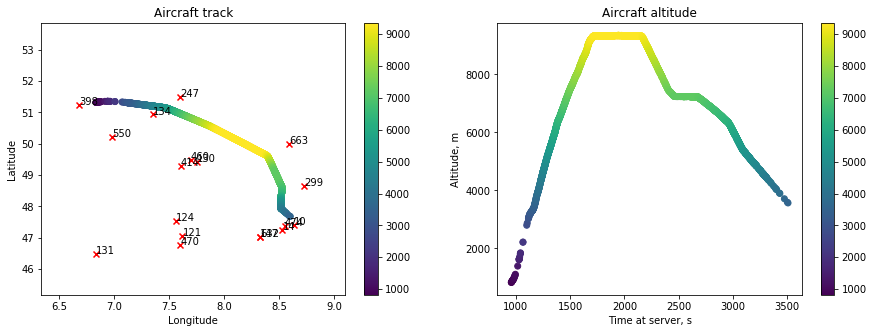

In [23]:
plot_track(train, [13], xpad=0.5, ypad=2.5)

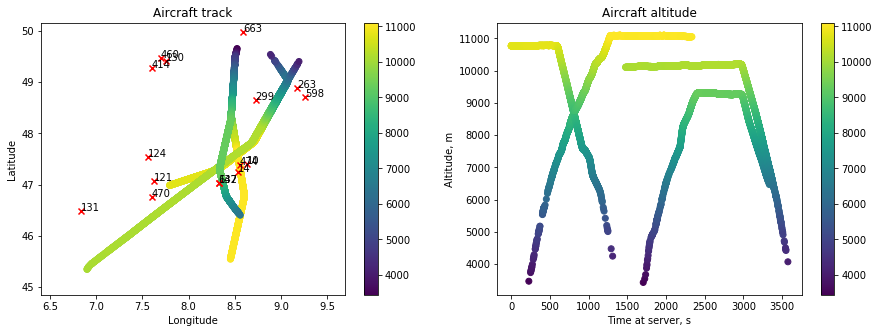

In [24]:
plot_track(train, [1564, 2731, 2770, 2073], xpad=0.5, ypad=0.5)

## Coordinate transformation from WGS84 to cartesian

Copy from here:
https://competition.opensky-network.org/documentation.html

In [25]:
class P3:
    def __init__(self, latitude, longitude, height):
        self.latitude = latitude
        self.longitude = longitude
        self.height = height
        
    # convert decimal degrees to radians
    def rad(self, degrees):
        return degrees * np.pi / 180.

    # convert radians to decimal degrees
    def deg(self, radians):
        return 180 * radians / np.pi

    # convert WSG84 coordinates to cartesian ones
    def to_cartesian(self):
        lat = self.rad(self.latitude)
        lon = self.rad(self.longitude)

        # WSG84 ellipsoid constants
        a = 6378137
        e = 8.1819190842622e-2

        # prime vertical radius of curvature
        N = a / np.sqrt(1 - pow(e, 2) * pow(np.sin(lat),2))

        return( (N + self.height) * np.cos(lat) * np.cos(lon),
                (N + self.height) * np.cos(lat) * np.sin(lon),
                ((1 - pow(e,2)) * N + self.height) * np.sin(lat) )

# 3D distance between WSG84 coordinates
def dist3d(p1, p2):
    x1, y1, z1 = p1.to_cartesian()
    x2, y2, z2 = p2.to_cartesian()
        
    return np.sqrt(pow(x1-x2,2) + pow(y1-y2,2) + pow(z1-z2,2))

## Create dictionaries to work with stations

Below I will need to create matrices and indices for the selected 33 stations.
Here I define some hash-map structures to get direct access to some information about a station by its number:

 | Name | Input | Output |
 |------|-------|--------|
 | st_dict | station number | station order |
 | st_dict_rev | station order | station number |
 | st_loc | station number | station location (P3 class instance) |
 | st_lat | station number | station latitude |
 | st_lon | station number | station longitude |

In [26]:
# returns station order by station number
# example for station 10: st_dict[10] = 0
st_dict = {}

# reverse map
# example for station 10: st_dict_rev[0] = 10
st_dict_rev = {}

st_loc = {}  # dict of P3 class instances for use in dist3d function
st_lat = {}  # station latitudes
st_lon = {}  # station longitudes

for i, s in enumerate(sorted(stations)):
    st_dict[s] = i
    st_dict_rev[i] = s
    
    station_geo = sensors.loc[sensors.serial==s, ['latitude', 'longitude', 'height']].values[0]
    st_loc[s] = P3(*station_geo)
    st_lat[s] = station_geo[0]
    st_lon[s] = station_geo[1]
    
st_dict

{10: 0,
 14: 1,
 121: 2,
 124: 3,
 130: 4,
 131: 5,
 132: 6,
 133: 7,
 134: 8,
 141: 9,
 142: 10,
 143: 11,
 147: 12,
 149: 13,
 208: 14,
 216: 15,
 247: 16,
 257: 17,
 263: 18,
 294: 19,
 299: 20,
 327: 21,
 398: 22,
 414: 23,
 460: 24,
 470: 25,
 474: 26,
 532: 27,
 550: 28,
 598: 29,
 632: 30,
 663: 31,
 670: 32}

## Station time measurements

In this round all stations are assumed to have GPS sensors and therefore synchronized.

I will define here two types of time for each station:
 - raw time measurements: timestamps measured by a station;
 - true time measurements: timestamps minus time required to a radiowave to pass distance between an aircraft and a station.

In [27]:
N = train.shape[0]
T = np.zeros([N, len(st_dict)])  # true station time measurements
T0 = np.zeros([N, len(st_dict)])  # raw station time measurements

lat = train.latitude.values
lon = train.longitude.values
hgt = train.geoAltitude.values
meas = train.measurements.values

for i in tqdm(range(N)):
    for w in eval(meas[i]):
        # true time measurement = station_measured_time - distance_to_aircraft / speed_of_light
        T[i, st_dict[w[0]]] = w[1] - dist3d(st_loc[w[0]], P3(lat[i], lon[i], hgt[i]))/0.299792458
        # raw time measurements 
        T0[i, st_dict[w[0]]] = w[1]

100%|██████████| 664031/664031 [01:21<00:00, 8122.27it/s]


In [28]:
## Raw time measurements can be used for aircraft localization (with poor accuracy though)

Text(0, 0.5, 'Latitude')

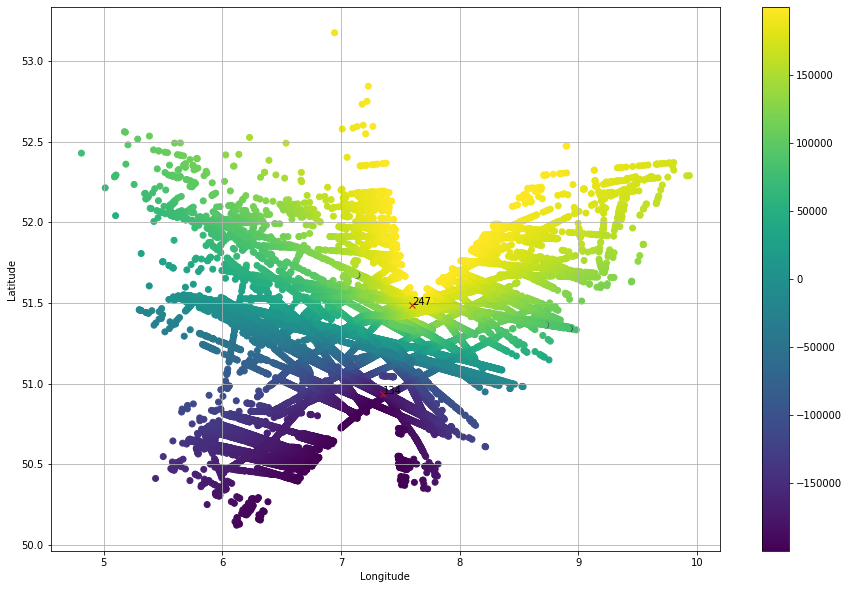

In [29]:
## Colorbar denotes delta T0 between two stations, points - records from train

# two stations
j1, j2 = 134, 247

# select records within a given range of delta T0 for two stations
ind = np.where((T0[:, st_dict[j1]] != 0) &
               (T0[:, st_dict[j2]] != 0) &
               ((T0[:, st_dict[j1]] - T0[:, st_dict[j2]]) > -2e5) &
               ((T0[:, st_dict[j1]] - T0[:, st_dict[j2]]) < 2e5))[0]

figsize(15, 10)
plt.scatter(train.longitude.values[ind],
            train.latitude.values[ind],
            c=T0[ind, st_dict[j1]] - T0[ind, st_dict[j2]])


s = sensors[sensors.serial.isin([j1, j2])]

# show station locations
plt.plot(s.longitude, s.latitude, 'rx')
for i in range(s.shape[0]):
    plt.text(s.longitude.values[i], s.latitude.values[i], str(s.serial.values[i]))
    
plt.colorbar()
plt.grid()
plt.xlabel('Longitude')
plt.ylabel('Latitude')

In [30]:
# Difference between true time T for two stations

Text(0, 0.5, 'Delta T, ns')

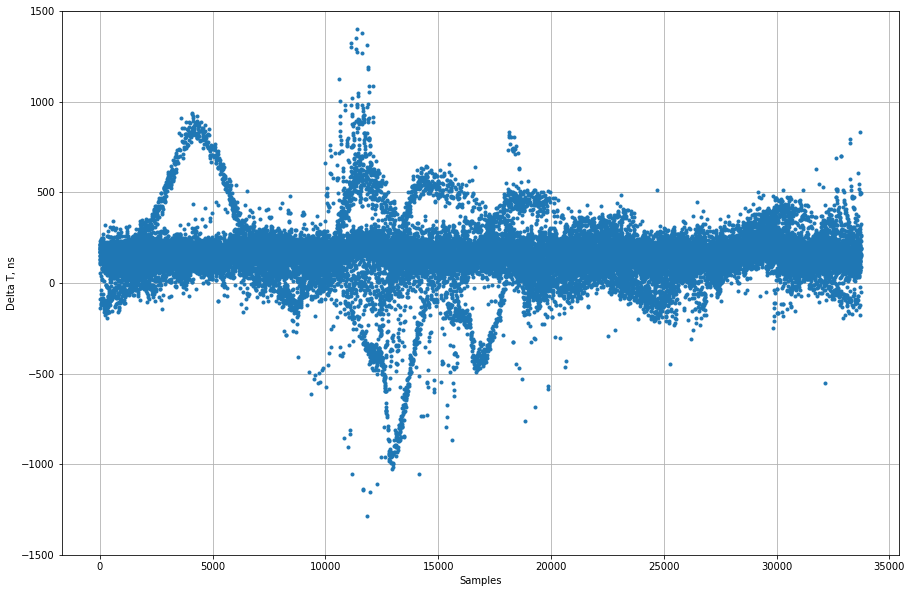

In [31]:
ind = np.where((T[:, st_dict[j1]]!=0) & (T[:, st_dict[j2]]!=0))[0]

plt.plot(T[ind, st_dict[j1]] - T[ind, st_dict[j2]], '.')
plt.ylim([-1.5e3, 1.5e3])
plt.grid()

plt.xlabel('Samples')
plt.ylabel('Delta T, ns')

## Aircraft velocity

In [32]:
# Function to calculate aircraft velocity by aircraft locations and station time measurements
#
# Input:
#   - aircraft: aircraft number
#   - min_meas: min number of measurements for station selection
#   - Nfilt: median filter parameter
#   - k: parameter - velocity calculated using ith and (i-k)th points
#
# Output:
#   - ts: timeAtServer timestamps
#   - velo_filt: velocity values calculated using ith and (i-k)th points
#   - velo_raw: velocity calculated using ith and (i-1)th points
#   - hgt: geoAltitude values

def get_velos(aircraft, min_meas=100, Nfilt=11, k=3):
    # indexes of aircraft messages
    x_ind = np.where(train.aircraft==aircraft)[0]

    # aircraft telemetry
    lat = train.latitude.values[x_ind]
    lon = train.longitude.values[x_ind]
    hgt = train.geoAltitude.values[x_ind]
    ts = train.timeAtServer.values[x_ind]

    # select stations receving messages from the aircraft
    sts = [st_dict_rev[i] for i in range(T0.shape[1]) if len(np.where(T0[x_ind, i]!=0)[0]) > min_meas]
    print(sts)
    
    # result
    velo_filt = np.nan * np.ones([len(x_ind), len(sts)])
    velo_raw = np.nan * np.ones([len(x_ind), len(sts)])
    
    for i in range(len(sts)):
        station = sts[i]
        j = st_dict[station]
    
        # indices with measurements for a j station
        ii = np.where(T0[x_ind, j].flatten() != 0)[0]

        # distance between aircraft and station
        dist = np.array([dist3d(P3(lat[i], lon[i], hgt[i]), st_loc[station]) for i in ii])

        # true time measurements
        t0 = T0[x_ind[ii], j].flatten() - dist/0.299792458
        
        # velocity calculated using ith and (i-1)th points
        res = (pd.DataFrame()
                  .assign(dt = np.array([(t0[i] - t0[i-1]) / 1e9 for i in range(1, len(ii))]),
                          dist = np.array([dist3d(P3(lat[ii[i]], lon[ii[i]], hgt[ii[i]]), P3(lat[ii[i-1]], lon[ii[i-1]], hgt[ii[i-1]])) for i in range(1, len(ii))]),
                          velocity = lambda x: x.dist / x.dt)
              )
        
        velo_raw[ii[1:], i] = res.velocity.values
        
        # velocity calculated using ith and (i-k)th points
        res = (pd.DataFrame()
                  .assign(dt2 = np.array([(t0[i] - t0[i-k]) / 1e9 for i in range(k, len(ii))]),
                          dist2 = np.array([dist3d(P3(lat[ii[i]], lon[ii[i]], hgt[ii[i]]), P3(lat[ii[i-k]], lon[ii[i-k]], hgt[ii[i-k]])) for i in range(k, len(ii))]),
                          velocity2 = lambda x: x.dist2 / x.dt2)
                 )
        
        v1 = res.velocity2.rolling(Nfilt).median().values
        v2 = res.velocity2.sort_index(ascending=False).rolling(Nfilt).median().values[::-1]
        velo = [0.5*(x+y) if not np.isnan(x) and not np.isnan(y) else x if not np.isnan(x) else y for x, y in zip(v1, v2)]
        
        velo_filt[ii[k:], i] = velo
        
        
    return ts, velo_filt, velo_raw, hgt

In [33]:
# Function to plot velocity values calculated using different stations
#
# Input:
#   - r: aircraft number
#
# Output: None

def plot_velos(r):
    ts, velo_filt, velo_raw, hgt = get_velos(r, Nfilt=11, k=3)
    
    figsize(15, 5)
    fig, ax1 = plt.subplots()
    _ = ax1.plot(ts, velo_filt, '.')
    ax1.set_xlabel('Time at server, s')
    ax1.set_ylabel('Velocity, m/s')
    #ax1.set_ylim([100, 1000])
    
    ax2 = ax1.twinx()
    _ = ax2.plot(ts, hgt, 'r-')
    ax2.set_ylabel('geoAltitude, m')

In [34]:
# Plot velocity for several aircrafts

[10, 141, 143, 147, 263, 474, 598, 632]


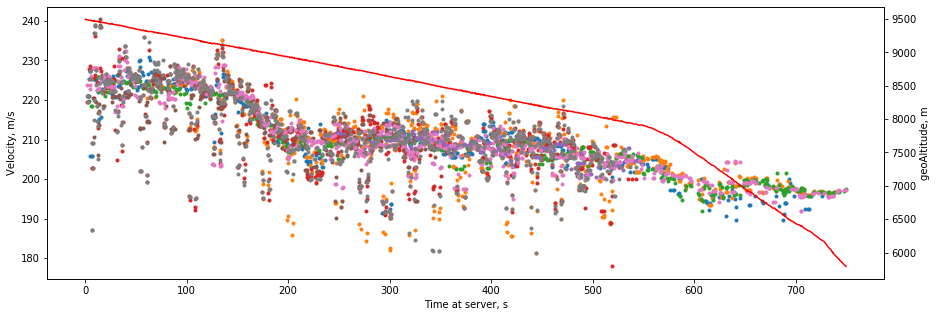

In [35]:
plot_velos(517)

[10, 124, 130, 134, 143, 147, 247, 257, 263, 299, 398, 414, 460, 550, 598, 632, 663, 670]


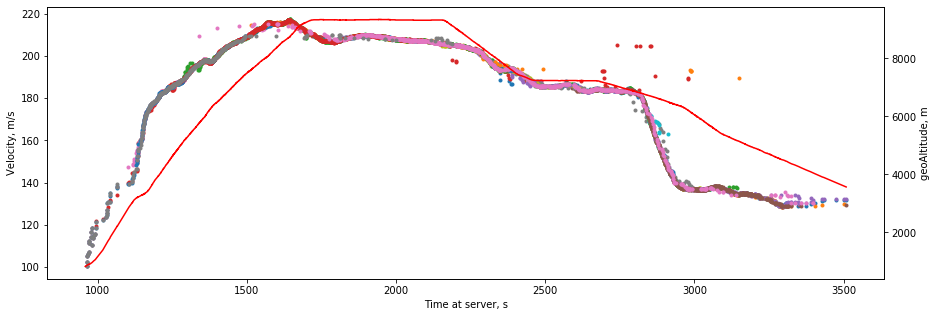

In [36]:
plot_velos(13)

[133, 142, 143, 149]


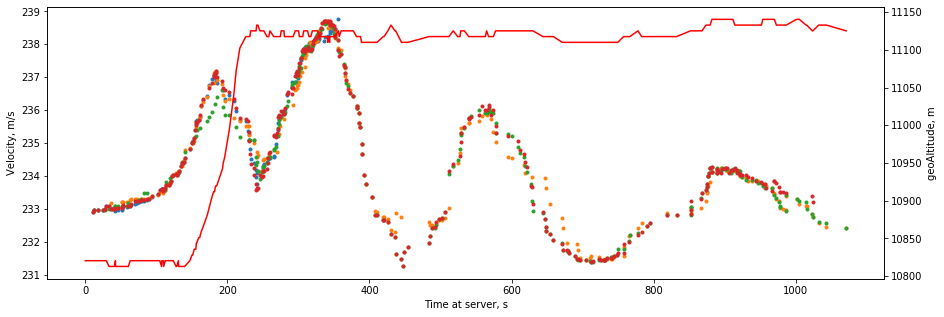

In [37]:
plot_velos(719)

## Simple solution (careful - about 2 hours computation time!)

The idea consists of the following steps:
 - for a given record T0 values are available from several stations (at least 3 required);
 - prepare delta T0 for a record;
 - find the closest points from train set by delta T0;
 - fit Linear Regressions separately for longitude and latitude values on points from train as functions of delta T0;
 - predict longitude and latitude for the record using Linear Regression.
 
**First, I checked how this works on one track from train and then predicted test.**

**Result on the leaderboard - 425m.**

P.S.: Implementation is not ideal here because I paste my original code with just some comments added.

In [38]:
from sklearn.linear_model import LinearRegression

def calc_geo(aircraft):
    # train points except for a given aircraft
    train_ind = np.where(train.aircraft!=aircraft)[0]
    # train points for the aircraft
    test_ind = np.where(train.aircraft==aircraft)[0]
    
    result = np.zeros([len(test_ind), 3])
    
    for i in tqdm(range(len(test_ind))):
        # stations available
        t_ind = np.where(T0[test_ind[i], :] !=0)[0]
        
        # indexes for train where measurements for all stations in t_ind are available
        x_ind = set(train_ind[np.where(T0[train_ind, t_ind[0]] !=0)[0]])
        for j in t_ind[1:]:
            x_ind = x_ind.intersection(train_ind[np.where(T0[train_ind, j] !=0)[0]])
        
        x_ind = np.array(list(x_ind))
        
        # If less than 30 records in train -> break
        if len(x_ind) < 30:
            result[i, :] = [0, 0, 0]
            continue
        
        # prepare delta T0 matrix. First column will store the 'distance' value, while others - delta T0
        T1 = np.zeros([len(x_ind), 1])
        for j in t_ind[1:]:
            T1 = np.c_[T1, T0[x_ind, j] - T0[x_ind, t_ind[0]]]
        
        # calculate a 'distance' between train points and the record
        for k, j in enumerate(t_ind[1:]):
            T1[:, 0] += pow(T1[:, k+1] - (T0[test_ind[i], j] - T0[test_ind[i], t_ind[0]]), 2)
        
        T1[:, 0] = np.sqrt(T1[:, 0])
        
        # Select indexes of 30 closest points from train
        ii = np.argsort(T1[:, 0])[:30]
        
        # fit Linear Regressions
        lr1 = LinearRegression().fit(T1[ii, 1:], train.latitude.values[x_ind[ii]])
        lr2 = LinearRegression().fit(T1[ii, 1:], train.longitude.values[x_ind[ii]])
        
        # predict position of the record 
        m = T0[test_ind[i], t_ind[1:]] - T0[test_ind[i], t_ind[0]]
        result[i, :-1] = [lr1.predict(np.array(m).reshape(1, m.shape[0]))[0],
                          lr2.predict(np.array(m).reshape(1, m.shape[0]))[0]]
        
        # estimate accuracy of prediction by calculating mean distance error for 5 closest points
        val = 0
        for j in ii[:5]:
            val += dist3d(P3(train.latitude.values[x_ind[j]],
                             train.longitude.values[x_ind[j]],
                             train.geoAltitude.values[x_ind[j]]),
                          P3(lr1.predict(T1[j, 1:].reshape(1, m.shape[0])),
                             lr2.predict(T1[j, 1:].reshape(1, m.shape[0])),
                             train.geoAltitude.values[x_ind[j]]))
            
        result[i, 2] = val/5.
        
    return result

In [39]:
# Predict track for 755 aircraft

In [40]:
result = calc_geo(755)

100%|██████████| 881/881 [02:06<00:00,  6.97it/s]


In [41]:
# Calculate errors of predicted points

In [42]:
lat_pred = result[:, 0]
lon_pred = result[:, 1]

X = train[train.aircraft==755]

err = []
for i in range(lat_pred.shape[0]):
    err.append(dist3d(P3(X.latitude.values[i],
                         X.longitude.values[i],
                         X.geoAltitude.values[i]),
                      P3(lat_pred[i],
                         lon_pred[i],
                         X.geoAltitude.values[i])))

In [43]:
# plot points with estimated accuracy < 500m

Ratio of selected points 0.8740068104426788


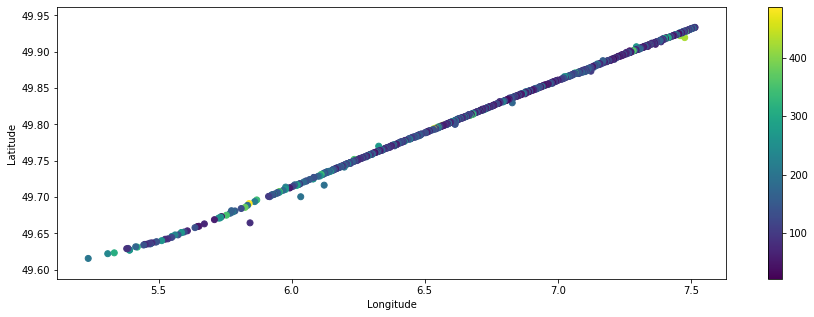

In [44]:
p = np.where((result[:, 2]<500)&(result[:, 2]!=0))[0]

print('Ratio of selected points', len(p)/len(lon_pred))

plt.scatter(lon_pred[p], lat_pred[p], c=result[p, 2])
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar()

In [45]:
# Distribution of errors

Text(0, 0.5, 'N')

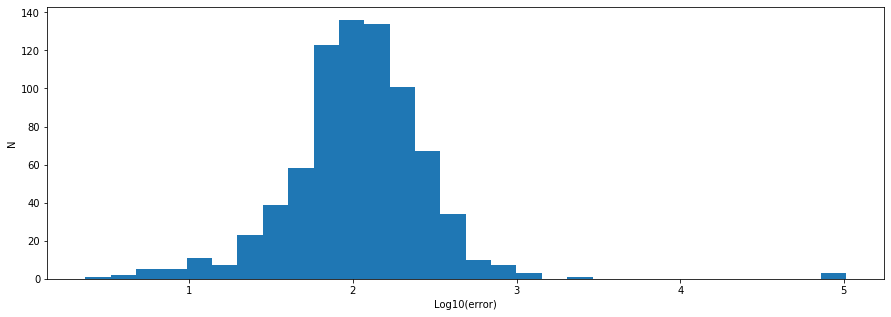

In [46]:
_ = plt.hist(np.log10((np.array(err))[p]), bins=30)
plt.xlabel('Log10(error)')
plt.ylabel('N')

## Predict test

In [47]:
# Prepare time measurements for test

test = df[(df.test==1)&(df.numMeasurements>2)]

N = test.shape[0]
Ttest = np.zeros([N, len(st_dict)])
meas = test.measurements.values

for i in tqdm(range(N)):
    for w in eval(meas[i]):
        Ttest[i, st_dict[w[0]]] = w[1]

100%|██████████| 72136/72136 [00:01<00:00, 56968.54it/s]


In [48]:
def calc_geo_test():
    
    result = np.zeros([test.shape[0], 3])
    
    for i in tqdm(range(test.shape[0])):
        # stations available
        t_ind = np.where(Ttest[i, :] !=0)[0]
        
        # indexes for train where measurements for all stations in t_ind are available
        x_ind = set(np.where(T0[:, t_ind[0]] !=0)[0])
        for j in t_ind[1:]:
            x_ind = x_ind.intersection(np.where(T0[:, j] !=0)[0])
            
        x_ind = np.array(list(x_ind))
        
        # If less than 40 records in train -> break
        if len(x_ind) < 40:
            result[i, :] = [0, 0, 0]
            continue
        
        # prepare delta T0 matrix. First column will store the 'distance' value, while others - delta T0
        T1 = np.zeros([len(x_ind), 1])
        for j in t_ind[1:]:
            T1 = np.c_[T1, T0[x_ind, j] - T0[x_ind, t_ind[0]]]
        
        # calculate a 'distance' between train points and the record
        for k, j in enumerate(t_ind[1:]):
            T1[:, 0] += pow(T1[:, k+1] - (Ttest[i, j] - Ttest[i, t_ind[0]]), 2)
            
        T1[:, 0] = np.sqrt(T1[:, 0])
        
        # Select indexes of 40 closest points from train
        ii = np.argsort(T1[:, 0])[:40]
        
        # fit Linear Regressions
        lr1 = LinearRegression().fit(T1[ii, 1:], train.latitude.values[x_ind[ii]])
        lr2 = LinearRegression().fit(T1[ii, 1:], train.longitude.values[x_ind[ii]])
        
        # predict position of the record
        m = Ttest[i, t_ind[1:]] - Ttest[i, t_ind[0]]
        result[i, :-1] = [lr1.predict(np.array(m).reshape(1, m.shape[0]))[0],
                          lr2.predict(np.array(m).reshape(1, m.shape[0]))[0]]
        
        # estimate accuracy of prediction by calculating mean distance error for 5 closest points
        val = 0
        for j in ii[:5]:
            val += dist3d(P3(train.latitude.values[x_ind[j]],
                             train.longitude.values[x_ind[j]],
                             train.geoAltitude.values[x_ind[j]]),
                          P3(lr1.predict(T1[j, 1:].reshape(1, m.shape[0])),
                             lr2.predict(T1[j, 1:].reshape(1, m.shape[0])),
                             train.geoAltitude.values[x_ind[j]]))
            
        result[i, 2] = val/5.
        
    return result

In [49]:
# Predict test

In [50]:
result = calc_geo_test()

100%|██████████| 72136/72136 [2:07:17<00:00,  9.45it/s]  


In [51]:
# Plot distribution of errors

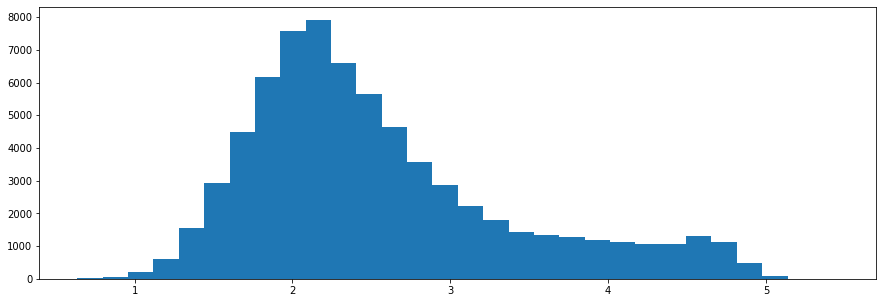

In [53]:
_=plt.hist(np.log10(result[np.where(result[:, 2]!=0)[0], 2]), bins=30)

In [ ]:
# Select a threshold so that at least 50% of points left

In [54]:
# The threshold of 1620m of error seems to be okay.

len(np.where((result[:, 2]!=0)&(result[:, 2]<1620))[0])/ 109474.

0.5053894075305552

In [55]:
# Prepare submission

In [56]:
X = (test
     .assign(latitude = result[:, 0],
             longitude = result[:, 1],
             # altitude is not checked in the first round of the competition
             geoAltitude = test['baroAltitude'],
             # estimated error
             dist = result[:, 2])
     # select points where algorithm predicted a vaue and apply a threshold of 1620m
     .loc[lambda x: (x.dist<1620) & (x.dist!=0)]
    )

X.shape

(57115, 12)

In [57]:
sample = pd.read_csv('test/round1_sample_empty.csv')

(sample[['id']].merge(X, on='id', how='left')
 .loc[:, ['id', 'latitude', 'longitude', 'geoAltitude']]
).to_csv('third_submission.csv', index=False)